<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRA1: Deep Reinforcement Learning

#### AUTOR: Mario Ubierna San Mamés
 

En esta práctica se hará un estudio sobre el entorno **highway-env**, donde inicialmente se realizará una exploración sobre el entorno, posteriormente implementaremos un agente DQN y finalmente mejoraremos el primer agente implementado

## 0. Contexto

**Highway-env** es un problema de conducción autónoma, donde tenemos múltiples carriles y varios coches transitando. Nuestro objetivo es que el agente sea capaz de controlar el vehículo con el fin de:

- Evitar colisiones con otros vehículos.
- Tener la máxima velocidad posible.
- Mantenerse en el carril derecho lo más posible.

El entorno se considera superado cuando en el tiempo de observación máximo establecido, se han verificado las tres condiciones anteriores.

![Alt Text](https://raw.githubusercontent.com/eleurent/highway-env/gh-media/docs/media/highway-env.gif?raw=true)

## 1. Entorno

Lo primero de todo es cargar las librerías necesarias:

In [1]:
import gym
import highway_env
from collections import namedtuple, deque
from copy import deepcopy, copy
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
import time

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.1 (0.5 ptos) - </strong> Exploración del entorno y representación de una ejecución aleatoria:
</div>

#### Exploración del entorno

Carga del entorno:

In [2]:
# Definimos el entorno
env = gym.make("highway-v0")

Información básica del entorno:

In [3]:
print("El espacio de acciones es {} ".format(env.action_space))
print("La dimensión del espacio de acciones es: {}".format(env.action_space.n))
# print("Las acciones por defecto son {}".format(str(env.action_type.actions_indexes)))
print("El espacio de observaciones es {} ".format(env.observation_space))
print("La dimensión del espacio de estados: {}".format(env.observation_space.shape[0]))
print("El rango de recompensas es {} ".format(env.reward_range))

El espacio de acciones es Discrete(5) 
La dimensión del espacio de acciones es: 5
El espacio de observaciones es Box([[-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]], [[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]], (5, 5), float32) 
La dimensión del espacio de estados: 5
El rango de recompensas es (-inf, inf) 


De la anterior ejecución podemos observar que, por defecto tanto la dimensión del espacio de acciones como de estados es 5. Estos valores vienen predefinidos a la hora de cargar el entorno **highway-v0**.  
  
Para saber más sobre la configuración por defecto del entorno ejecutamos la siguiente instrucción:

In [4]:
env.env.default_config()

{'observation': {'type': 'Kinematics'},
 'action': {'type': 'DiscreteMetaAction'},
 'simulation_frequency': 15,
 'policy_frequency': 1,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 150,
 'centering_position': [0.3, 0.5],
 'scaling': 5.5,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'lanes_count': 4,
 'vehicles_count': 50,
 'controlled_vehicles': 1,
 'initial_lane_id': None,
 'duration': 40,
 'ego_spacing': 2,
 'vehicles_density': 1,
 'collision_reward': -1,
 'right_lane_reward': 0.1,
 'high_speed_reward': 0.4,
 'lane_change_reward': 0,
 'reward_speed_range': [20, 30],
 'offroad_terminal': False}

Como podemos ver obtenemos la siguiente información:  
- El tipo de observación es Kinematics, esto lo que significa es que el espacio de estados va a ser una matriz del tipo VxF, donde V es el número de vehículos cercanos a nuestro coche y F el número de características (['presence', 'x', 'y', 'vx', 'vy']).

- El tipo de acciones es DiscreteMetaAction, en este caso hay 5 acciones. La primera es movernos al carril de la izquierda "0", la segunda es un movimiento ilegal o mantenernos en el carril actual a la velocidad actual "1" (cuando se produce un cambio de carril en el límite de la carretera, o cuando la acelaración o desaceleración es mayor o menor que la velocidad máxima/mínima) "1", la tercera es movernos al carril de la derecha "2", la cuarta es aumentar la velocidad "3" y la quinta reducir la velocidad "4".

- El número de carriles es 4, se puede modificar para añadir más o menos.

- El número de vehículos es 50 y al igual que antes se puede modificar.

- La recompensa por colisión es -1.

- La recompensa por estar en el carril de la derecha es 0.1.

- La recompensa por alcanzar una alta velocidad es 0.4.

- La recompensa por cambiar de carril es 0.

- Y la recompensa por aumentar o disminuir la velocidad varía entre 20 y 30 dependiendo de forma lineal a su velocidad.

A continuación podemos ver un ejemplo de una acción tomada aleatoriamente y todas las posibles acciones que podemos tomar:

In [5]:
print("Acción aleatoria tomada {}".format(env.action_space.sample()))
print("Las posibles acciones son {}".format(env.action_type.actions_indexes))

Acción aleatoria tomada 0
Las posibles acciones son {'LANE_LEFT': 0, 'IDLE': 1, 'LANE_RIGHT': 2, 'FASTER': 3, 'SLOWER': 4}


Para concluir con la exploración del entorno, vamos a mostrar un ejemplo de un estado según el espacio de observaciones por defecto junto el nombre de cada columna:

In [6]:
print("Un estado aleatorio sería \n{}".format(env.observation_space.sample()))
print("El nombre de cada columna (característica \"F\") es {}".format(env.env.observation_type.features))

Un estado aleatorio sería 
[[ 0.56269795  0.02629488  1.028781    0.16131678 -2.029417  ]
 [-0.07037026  0.32593936  0.23820072  1.5828505   0.43329716]
 [ 0.44599968 -0.46243614  1.8783402  -1.6268619   1.7831517 ]
 [-0.19314598  0.54335874  1.4246894  -0.9136193   0.54912966]
 [-0.1745654   0.7565486   0.21387763  1.6658678   1.7573118 ]]
El nombre de cada columna (característica "F") es ['presence', 'x', 'y', 'vx', 'vy']


#### Representación de una ejecución aleatoria

Obs inicial:


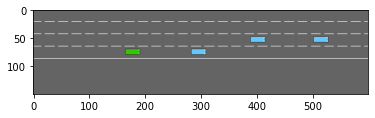


Acción: IDLE -> recommpensa: 0.8666666666666667
Nuevo estado:


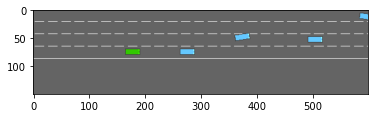


Acción: LANE_RIGHT -> recommpensa: 0.8666666666666667
Nuevo estado:


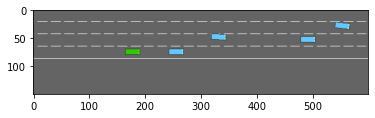


Acción: LANE_RIGHT -> recommpensa: 0.8666666666666667
Nuevo estado:


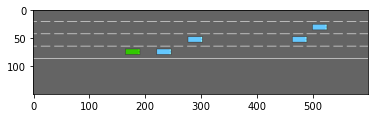


Acción: IDLE -> recommpensa: 0.8666666666666667
Nuevo estado:


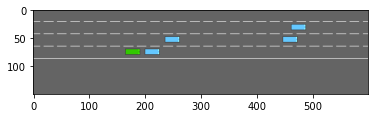


Acción: LANE_LEFT -> recommpensa: 0.04444444444444443
Nuevo estado:


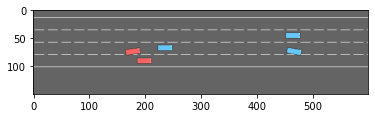

Episodio terminado después de 5 pasos y la recompensa fue 3.511111111111111


In [7]:
obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial:")
plt.imshow(env.render(mode="rgb_array"))
plt.show()
# print(obs)

while not done:
    # Obtener la acción y la ejecutamos
    action = env.action_space.sample()
    new_obs, reward, done, info = env.step(action)
    
    # Imprimimos el paso
    print("\nAcción: {} -> recommpensa: {}".format(env.action_type.actions[action], reward))
    print("Nuevo estado:")
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
    env.close()
#     print(new_obs)
    
    t += 1
    total_reward += reward
    obs = new_obs
    
print("Episodio terminado después de {} pasos y la recompensa fue {}".format(t, total_reward))

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.2 (0.5 ptos) - </strong> Explicar los diferentes espacios de observaciones y de acciones:
</div>

Resuelto en el informe

## 2. Agente de referencia

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.1 (1.5 ptos) - </strong> Implementar un agente DQN con la observación kinematics
</div>

Lo primero de todo es definir la clase que nos va a permitir crear el replay buffer:

In [8]:
class experienceReplayBuffer:

    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer', 
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size, 
                                   replace=False)
        # Use asterisk operator to unpack deque 
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

Posteriormente tenemos que crear la red neuronal:

In [9]:
class NeuralNet(torch.nn.Module):  

    def __init__(self, env, learning_rate=1e-3):
        
        """
        Params
        ======
        n_inputs: tamaño del espacio de estadps
        n_outputs: tamaño del espacio de acciones
        actions: array de acciones posibles
        """
        ######################################
        ##TODO: Inicializar parámetros
        super(NeuralNet, self).__init__()
        self.n_inputs = env.observation_space.shape[0] * env.observation_space.shape[1]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.learning_rate = learning_rate
        
        #######################################
        ##TODO: Neural network
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.n_outputs, bias=True),
        )
        
        #######################################
        ##TODO: Initialize optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)


    ### e-greedy method
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)  # acción random
        else:
            qvals = self.get_qvals(np.reshape(state, (self.n_inputs,)))  # acción del cálculo de Q para esta acción
            action= torch.max(qvals, dim=-1)[1].item()
        return action
    
    
    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array([np.ravel(s) for s in state])
        state_t = torch.FloatTensor(state)
        return self.model(state_t)

Luego tenemos que crear el agente:

In [10]:
class DQNAgent:
    
    ######################################
    ##TODO 1: Declarar variables
    def __init__(self, env, main_network, buffer, reward_threshold, epsilon=0.1, eps_decay=0.99, batch_size=32):
        
        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(main_network) 
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.reward_threshold = reward_threshold
        self.nblock = 100 # bloque de los X últimos episodios de los que se calculará la media de recompensas
        self.initialize()
        
    ######################################
    ##TODO 2: Inicializar otras variables necesarias
    def initialize(self):
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.update_position = []
        self.history_loss = []
        self.update_epsilon = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset()
    
    ######################################
    ##TODO 3: Tomar paso siguiente
    def take_step(self, eps, mode='train'):
        if mode == 'explore': 
            action = self.env.action_space.sample()  # acción aleatoria en el burn-in
        else:
            action = self.main_network.get_action(self.state0, eps) # acción a partir del valor de Q (elección de la acción con mejor Q)
            self.step_count += 1
            
        #TODO: tomar 'step' i obtener nuevo estado y recompensa. Guardar la experiencia en el buffer
        new_state, reward, done, _ = self.env.step(action)
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state)
        self.state0 = new_state.copy()
        
        #TODO: resetear entorno 'if done'
        if done:
            self.update_position.append(self.state0[0]) # Guardamos la posición final de cada episodio
            self.state0 = self.env.reset()
        return done

    ## TRAINING
    def train(self, gamma=0.99, max_episodes=50000, 
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000):
        
        self.gamma = gamma

        # Rellenamos el buffer con N experiencias aleatorias ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

            
        episode = 0
        training = True
        print("Training...")
        while training:
            self.state0 = self.env.reset()
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # El agente toma una acción
                gamedone = self.take_step(self.epsilon, mode='train')
                
                #################################################################################
                #####TODO 4:  Actualizar la red principal según la frecuencia establecida #######
                if self.step_count % dnn_update_frequency == 0:
                    self.update()
                    
                ########################################################################################
                ###TODO 6: Sincronizar red principal y red objetivo según la frecuencia establecida#####
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict()
                    )
                    self.sync_eps.append(episode)
                
                if gamedone:                   
                    episode += 1
                    
                    # Guardamos la evolución de la pérdida
                    self.history_loss.append(np.mean(self.update_loss))
                        
                    self.update_loss = []
                                    
                    #######################################################################################
                    ###TODO 7: calcular la media de recompensa de los últimos X episodios, y almacenar
                    self.training_rewards.append(self.total_reward)
                    mean_rewards = np.mean(
                        self.training_rewards[-self.nblock:]
                    )
                    self.mean_training_rewards.append(mean_rewards)

                    self.update_epsilon.append(self.epsilon) # Guardamos la evolución de epsilon
                    
                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {}\t\t".format(
                        episode, mean_rewards, self.epsilon), end="")
                    
                    #######################################################################################
                    ### TODO 8: Comprobar que todavía quedan episodios. Parar el aprendizaje si se llega al límite
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached')
                        break
                    
                    #Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego  
                    if mean_rewards >= self.reward_threshold:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(
                            episode))
                        break
                    
                    #################################################################################
                    ######TODO 9: Actualizar epsilon según la velocidad de decaimiento fijada########
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)

                    
    #####################################         
    #####TODO 5: cálculo de la pérdida###
    def calculate_loss(self, batch):
        # Separamos las variables de la experiencia y las convertimos a tensores 
        states, actions, rewards, dones, next_states = [i for i in batch] 
        rewards_vals = torch.FloatTensor(rewards)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1)
        dones_t = torch.ByteTensor(dones)
        
        # Obtenemos los valores de Q de la red principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)
        # Obtenemos los valores de Q objetivo. El parámetro detach() evita que estos valores actualicen la red objetivo
        qvals_next = torch.max(self.target_network.get_qvals(next_states),
                               dim=-1)[0].detach()
        qvals_next[dones_t] = 0 # 0 en estados terminales
        
        #################################################################################
        ### TODO: Calcular ecuación de Bellman
        expected_qvals = self.gamma * qvals_next + rewards_vals
        
        #################################################################################
        ### TODO: Calcular la pérdida (MSE)
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        
        return loss

    
    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionamos un conjunto del buffer
        loss = self.calculate_loss(batch) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.main_network.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        self.update_loss.append(loss.detach().numpy())
        
    def plot_rewards(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.training_rewards, label='Rewards')
        plt.plot(self.mean_training_rewards, label='Mean Rewards')
        plt.title("Evolución de las recompensas")
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(loc="upper left")
        plt.show()
        
    def plot_loss(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.history_loss)
        plt.title("Evolución de la pérdida")
        plt.xlabel('Episode')
        plt.ylabel('Loss')
        plt.show()
        
    def plot_epsilon(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.update_epsilon)
        plt.title("Evolución de epsilon")
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')
        plt.show()

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.2 (1 ptos) - </strong> Entrenar el agente y buscar los hiperparámetros óptimos:
</div>

Para definir los hiperparámetras se han ejecutado muchos entrenamientos sobre el agente de referencia, algunos de estos entrenamientos tanto la configuración como la calidad del agente los podemos encontrar en el informe.  
  
Por lo tanto, los hiperparámetros que encontramos a continuación son los mejores a los que se ha llegado.

In [11]:
# Definición de los hiperparámetros

lr = 0.001            # Velocidad de aprendizaje
BATCH_SIZE = 64      # Tamaño del batch
MAX_EPISODES = 1000   # Número de episodios
BURN_IN = 1000        # Número de episodios para rellenar el buffer
DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
DNN_SYNC = 100      # Frecuencia de sincronización con la red objetivo
MEMORY_SIZE = 10000   # Capacidad máxima del buffer
GAMMA = 0.8          # Factor de descuento
EPSILON = 1           # Epsilon
EPSILON_DECAY = 0.99   # Decaimiento de epsilon
REWARD_THRESHOLD = 26 # Recompensa con la que el agente para de entrenar

En vez definidos los hiperparámetros, creamos tanto la red neuronal, el buffer para el entranamiento y el agente.

Una vez hecho todo eso pasamos a entrenar a nuestro agente DQN con la observación de tipo kinematics.

In [12]:
# Carga de la red neuronal
dqn = NeuralNet(env, learning_rate=lr)

# Creación del buffer
buffer = experienceReplayBuffer(
    memory_size=MEMORY_SIZE, 
    burn_in=BURN_IN
)

# Creación del agente
agent_dqn = DQNAgent(
    env=env,
    main_network=dqn,
    buffer=buffer,
    reward_threshold=REWARD_THRESHOLD, 
    epsilon=EPSILON,
    eps_decay=EPSILON_DECAY,
    batch_size=BATCH_SIZE
)

# Entrenamos el agente
agent_dqn.train(
    gamma=GAMMA, 
    max_episodes=MAX_EPISODES, 
    batch_size=BATCH_SIZE,  
    dnn_update_frequency=DNN_UPD, 
    dnn_sync_frequency=DNN_SYNC
)

Filling replay buffer...
Training...


<ipython-input-10-bdc9f4a49d4e>:145: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1273.)
  qvals_next[dones_t] = 0 # 0 en estados terminales


Episode 207 Mean Rewards 21.35 Epsilon 0.12613920430197123		

C:\Users\mario\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mario\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 652 Mean Rewards 26.11 Epsilon 0.01		2118606165716			
Environment solved in 652 episodes!


Lo siguiente que debemos realizar es guardar el modelo entrenado, para así poder hacer uso después del mismo sin necesidad de volver a entrenar al agente. Posteriormente, visualizamos el entrenamiento del agente a partir de las recompensas obtenidas y de la pérdida de la red.

In [13]:
# Guardamos el modelo entrenado
trained_model = {
    "state_dic" : agent_dqn.main_network.state_dict()
}
torch.save(trained_model, "DQN.pth")

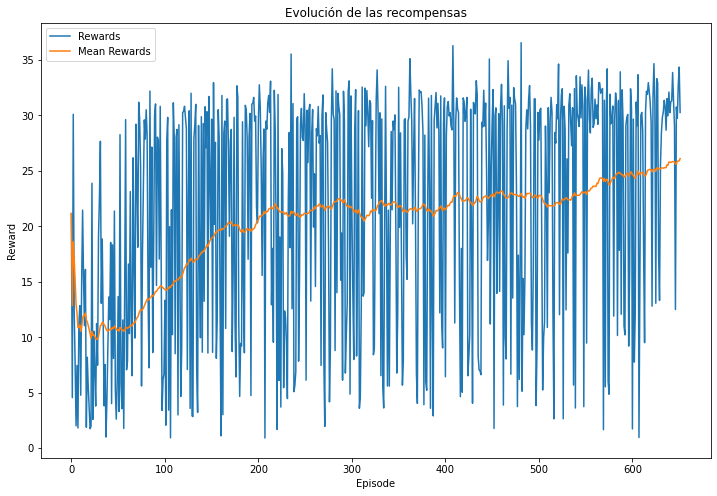

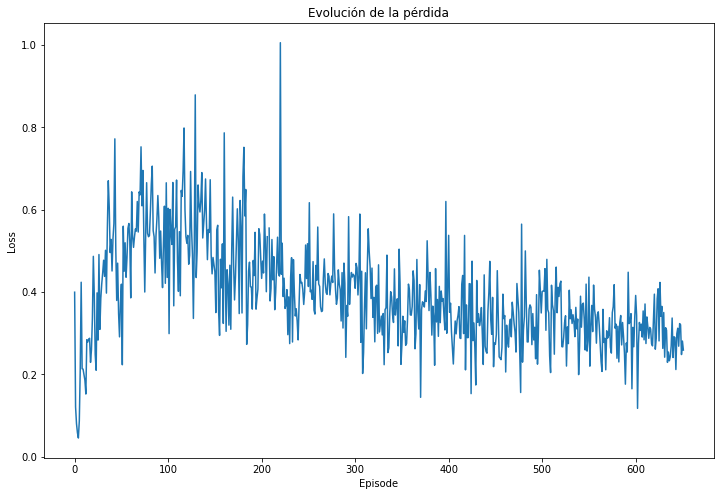

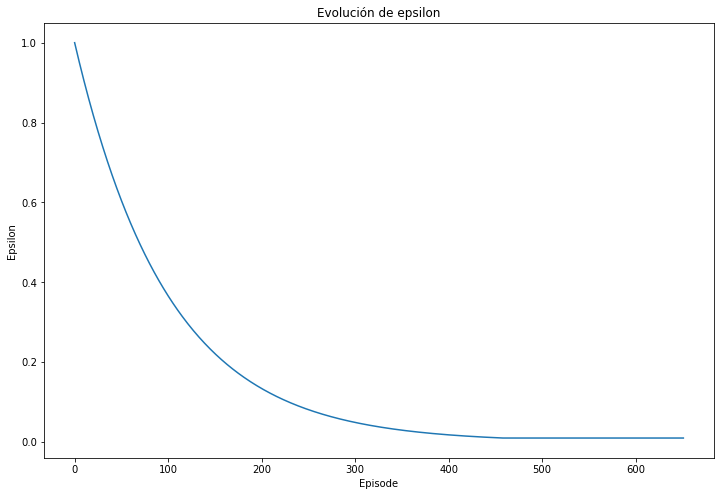

In [14]:
agent_dqn.plot_rewards()
agent_dqn.plot_loss()
agent_dqn.plot_epsilon()

### Comentarios

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.3 (0.5 ptos) - </strong> Probar el agente y mostrar el comportamiento del mismo:
</div>

Primero vamos a realizar una ejecución del agente en el entorno de prueba a nivel visual, básicamente para ver cómo se comporta.

Obs inicial:


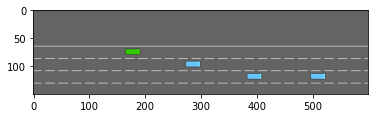


Acción: FASTER -> recommpensa: 0.9105482353831814
Nuevo estado:


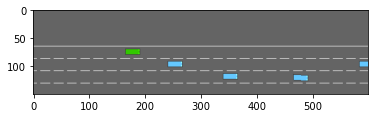


Acción: LANE_LEFT -> recommpensa: 0.9294396281688483
Nuevo estado:


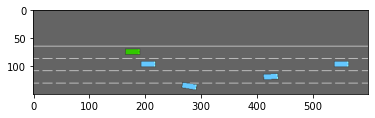


Acción: LANE_LEFT -> recommpensa: 0.9326679449316199
Nuevo estado:


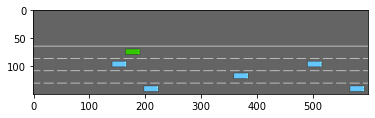


Acción: LANE_LEFT -> recommpensa: 0.9332196262840239
Nuevo estado:


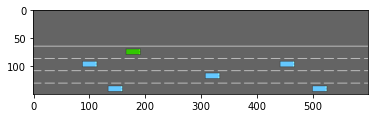


Acción: LANE_LEFT -> recommpensa: 0.9333139021364123
Nuevo estado:


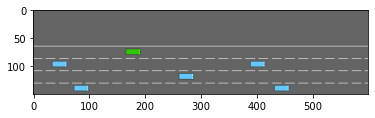


Acción: LANE_LEFT -> recommpensa: 0.9333300127703947
Nuevo estado:


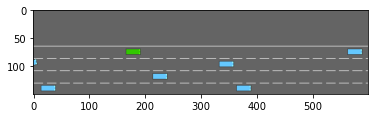


Acción: LANE_LEFT -> recommpensa: 0.9333327658881948
Nuevo estado:


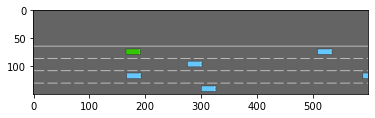


Acción: SLOWER -> recommpensa: 0.8227850009804542
Nuevo estado:


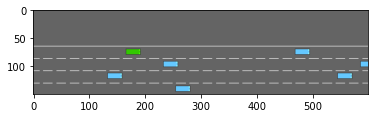


Acción: LANE_LEFT -> recommpensa: 0.8038936885935047
Nuevo estado:


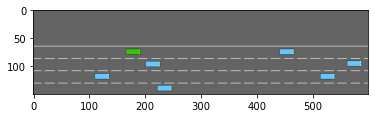


Acción: FASTER -> recommpensa: 0.9112136209531093
Nuevo estado:


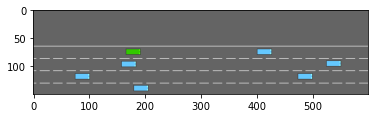


Acción: LANE_LEFT -> recommpensa: 0.929553334734239
Nuevo estado:


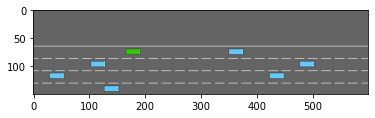


Acción: SLOWER -> recommpensa: 0.8221391406626637
Nuevo estado:


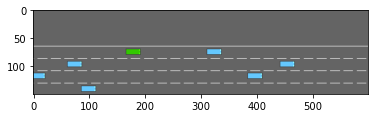


Acción: LANE_RIGHT -> recommpensa: 0.8260055408862046
Nuevo estado:


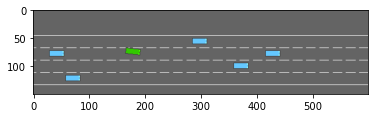


Acción: LANE_RIGHT -> recommpensa: 0.8450909690919605
Nuevo estado:


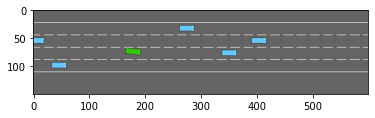


Acción: FASTER -> recommpensa: 0.9551031632832822
Nuevo estado:


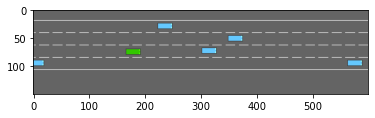


Acción: SLOWER -> recommpensa: 0.8633547175528039
Nuevo estado:


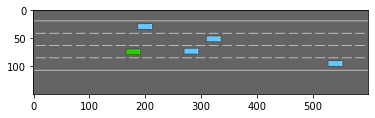


Acción: SLOWER -> recommpensa: 0.7371277522490488
Nuevo estado:


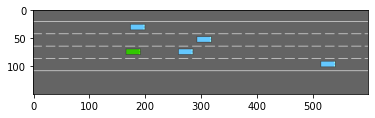


Acción: IDLE -> recommpensa: 0.7155570489860752
Nuevo estado:


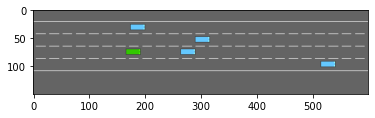


Acción: IDLE -> recommpensa: 0.7118708695858212
Nuevo estado:


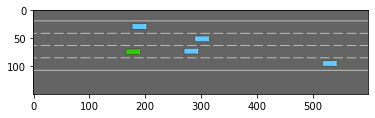


Acción: IDLE -> recommpensa: 0.7112409448955964
Nuevo estado:


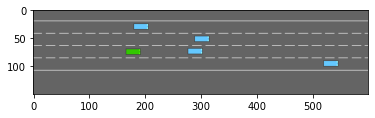


Acción: IDLE -> recommpensa: 0.7111332981773367
Nuevo estado:


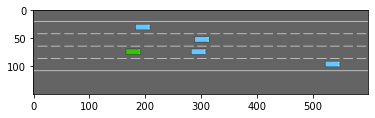


Acción: IDLE -> recommpensa: 0.7111149026196899
Nuevo estado:


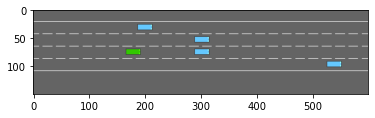


Acción: FASTER -> recommpensa: 0.8216599944185
Nuevo estado:


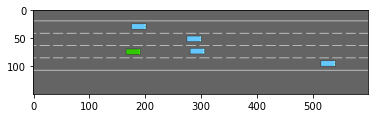


Acción: FASTER -> recommpensa: 0.9510990853857645
Nuevo estado:


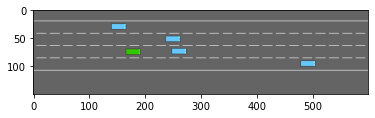


Acción: SLOWER -> recommpensa: 0.8626704677495916
Nuevo estado:


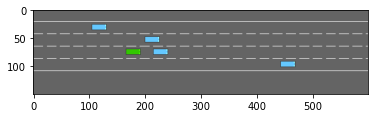


Acción: LANE_RIGHT -> recommpensa: 0.8697812796135382
Nuevo estado:


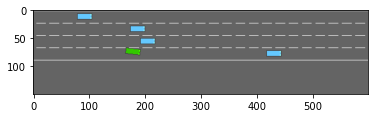


Acción: LANE_RIGHT -> recommpensa: 0.8671989173747012
Nuevo estado:


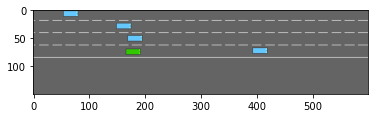


Acción: LANE_RIGHT -> recommpensa: 0.8667576220505412
Nuevo estado:


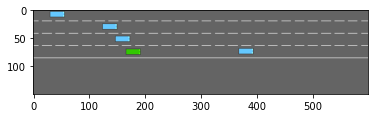


Acción: LANE_RIGHT -> recommpensa: 0.8666822098716468
Nuevo estado:


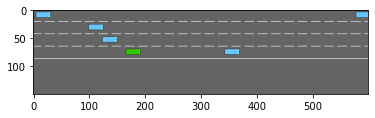


Acción: FASTER -> recommpensa: 0.9772175582007075
Nuevo estado:


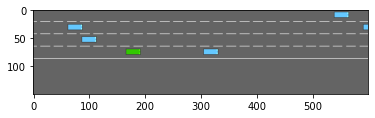


Acción: LANE_LEFT -> recommpensa: 0.973884526518224
Nuevo estado:


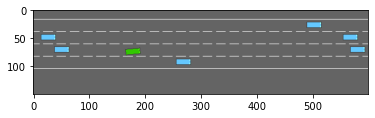


Acción: LANE_LEFT -> recommpensa: 0.9548902447208544
Nuevo estado:


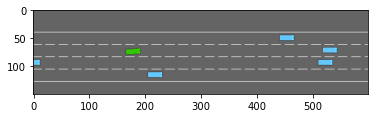


Acción: LANE_LEFT -> recommpensa: 0.9332196395393136
Nuevo estado:


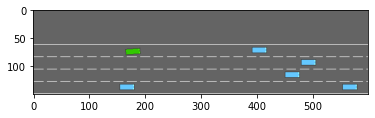


Acción: LANE_LEFT -> recommpensa: 0.9333139044015853
Nuevo estado:


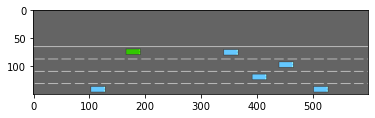


Acción: LANE_RIGHT -> recommpensa: 0.9555522353797086
Nuevo estado:


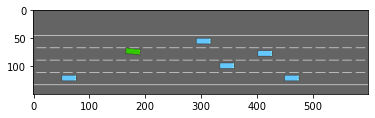


Acción: LANE_RIGHT -> recommpensa: 0.9777772103987886
Nuevo estado:


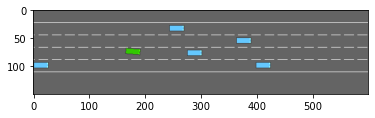


Acción: SLOWER -> recommpensa: 0.8672294454362026
Nuevo estado:


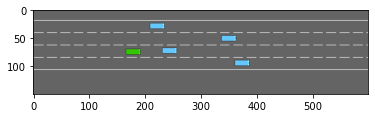


Acción: SLOWER -> recommpensa: 0.7377898976566994
Nuevo estado:


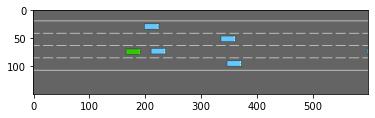


Acción: LANE_RIGHT -> recommpensa: 0.7378924240680766
Nuevo estado:


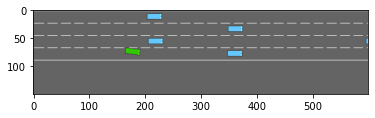


Acción: IDLE -> recommpensa: 0.734112428300494
Nuevo estado:


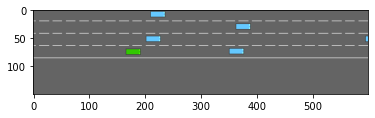

Episodio terminado después de 40 pasos y la recompensa fue 34.4717651998994


In [21]:
# Carga del modelo entrenado
modelo = torch.load("DQN.pth")['state_dic']
agent_dqn.main_network.load_state_dict(modelo)

obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial:")
plt.imshow(env.render(mode="rgb_array"))
plt.show()
# print(obs)

while not done:
    # Obtener la acción y la ejecutamos
    action = agent_dqn.main_network.get_action(obs)
    new_obs, reward, done, info = env.step(action)
    
    # Imprimimos el paso
    print("\nAcción: {} -> recommpensa: {}".format(env.action_type.actions[action], reward))
    print("Nuevo estado:")
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
    env.close()
#     print(new_obs)
    
    t += 1
    total_reward += reward
    obs = new_obs
    
print("Episodio terminado después de {} pasos y la recompensa fue {}".format(t, total_reward))

Vamos a visualizar el comportamiento del agente durante 100 episodios para ver cómo se comporta, es decir,  cómo es de bueno nuestro agente a partir de las recompensas obtenidas.

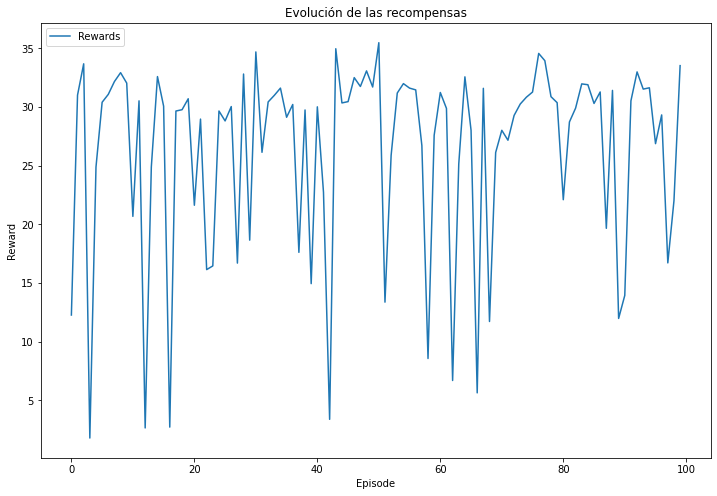

In [22]:
# Carga del modelo entrenado
modelo = torch.load("DQN.pth")['state_dic']
agent_dqn.main_network.load_state_dict(modelo)

rew_episodio = []
for episodio in range(100):
    obs = env.reset()
    pos_paso = []
    rew_paso = 0
    
    while True:
        
        accion = agent_dqn.main_network.get_action(obs) # USO DEL MODELO
        new_obs, reward, done, info = env.step(accion)
        
        obs = new_obs
        rew_paso += reward
        
        if done:
            break
            
    rew_episodio.append(rew_paso)

plt.figure(figsize=(12,8))
plt.plot(rew_episodio, label='Rewards')
plt.title("Evolución de las recompensas")
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(loc="upper left")
plt.show()

## 3. Propuesta de mejora

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 3.1 (2 ptos) - </strong> Implementar un agente DQN con otra observación diferente a kinematics:
</div>

#### Comentar la elección de la observación y por qué del agente DQN

Lo primero de todo es seleccionar el tipo de observación "OccupancyGrid":

In [23]:
env = gym.make('highway-v0')
env.configure({
    "observation": {
        "type": "OccupancyGrid"
    }
})
_ = env.reset()

Al cambiar el tipo de observación tenemos que hacer una pequeña modificación en la clase de la red neuronal, para que a la hora de hacer uso de la misma funcione.

El cambio no es más que cambiar el número de entradas de la red neuronal, ya que al cambiar el tipo de observación éstas también cambian:

In [24]:
class NeuralNet(torch.nn.Module):  

    def __init__(self, env, learning_rate=1e-3):
        
        """
        Params
        ======
        n_inputs: tamaño del espacio de estadps
        n_outputs: tamaño del espacio de acciones
        actions: array de acciones posibles
        """
        ######################################
        ##TODO: Inicializar parámetros
        super(NeuralNet, self).__init__()
        self.n_inputs = env.observation_space.shape[0] * env.observation_space.shape[1] * env.observation_space.shape[2]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.learning_rate = learning_rate
        
        #######################################
        ##TODO: Neural network
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.n_outputs, bias=True),
        )
        
        #######################################
        ##TODO: Initialize optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)


    ### e-greedy method
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)  # acción random
        else:
            qvals = self.get_qvals(np.reshape(state, (self.n_inputs,)))  # acción del cálculo de Q para esta acción
            action= torch.max(qvals, dim=-1)[1].item()
        return action
    
    
    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array([np.ravel(s) for s in state])
        state_t = torch.FloatTensor(state)
        return self.model(state_t)

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 3.2 (2 ptos) - </strong> Entrenar el agente y buscar los hiperparámetros óptimos:
</div>

Para definir los hiperparámetras se han ejecutado muchos entrenamientos, algunos de estos entrenamientos tanto la configuración como la calidad del agente los podemos encontrar en el informe.  
  
Por lo tanto, los hiperparámetros que encontramos a continuación son los mejores a los que se ha llegado:

In [25]:
# Definición de los hiperparámetros

lr = 0.001            # Velocidad de aprendizaje
BATCH_SIZE = 64      # Tamaño del batch
MAX_EPISODES = 1000   # Número de episodios
BURN_IN = 1000        # Número de episodios para rellenar el buffer
DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
DNN_SYNC = 500      # Frecuencia de sincronización con la red objetivo
MEMORY_SIZE = 10000   # Capacidad máxima del buffer
GAMMA = 0.8          # Factor de descuento
EPSILON = 1           # Epsilon
EPSILON_DECAY = 0.99   # Decaimiento de epsilon
REWARD_THRESHOLD = 32 # Recompensa con la que el agente para de entrenar

Con los hiperparámetros encontrado podemos entrenar al agente para resolver el problema:

In [30]:
# Carga de la red neuronal
dqn_occupancy = NeuralNet(env, learning_rate=lr)

# Creación del buffer
buffer = experienceReplayBuffer(
    memory_size=MEMORY_SIZE, 
    burn_in=BURN_IN
)

# Creación del agente
agent_dqn_occupancy = DQNAgent(
    env=env,
    main_network=dqn_occupancy,
    buffer=buffer,
    reward_threshold=REWARD_THRESHOLD,
    epsilon=EPSILON,
    eps_decay=EPSILON_DECAY,
    batch_size=BATCH_SIZE
)

# Entrenamos el agente
agent_dqn_occupancy.train(
    gamma=GAMMA, 
    max_episodes=MAX_EPISODES, 
    batch_size=BATCH_SIZE,  
    dnn_update_frequency=DNN_UPD, 
    dnn_sync_frequency=DNN_SYNC
)

Filling replay buffer...
Training...


<ipython-input-10-bdc9f4a49d4e>:145: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1273.)
  qvals_next[dones_t] = 0 # 0 en estados terminales


Episode 1000 Mean Rewards 31.56 Epsilon 0.01		118606165716			
Episode limit reached


Guardamos el modelo y mostramos cómo ha sido el entrenamiento del agente:

In [31]:
# Guardamos el modelo entrenado
trained_model = {
    "state_dic" : agent_dqn_occupancy.main_network.state_dict()
}
torch.save(trained_model, "DQN_occupancy.pth")

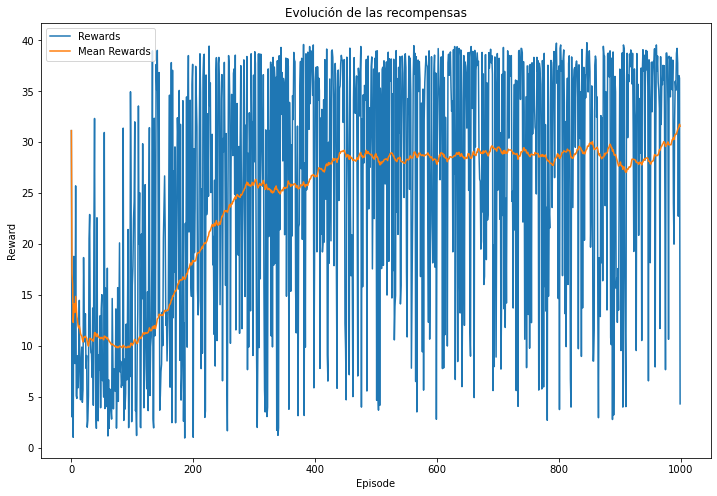

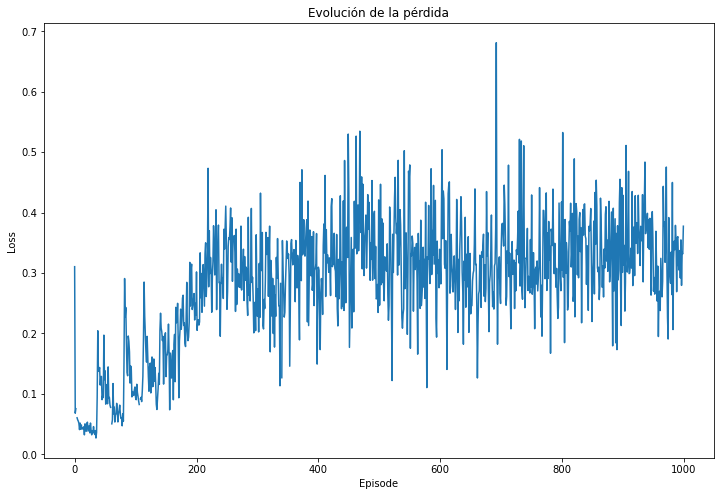

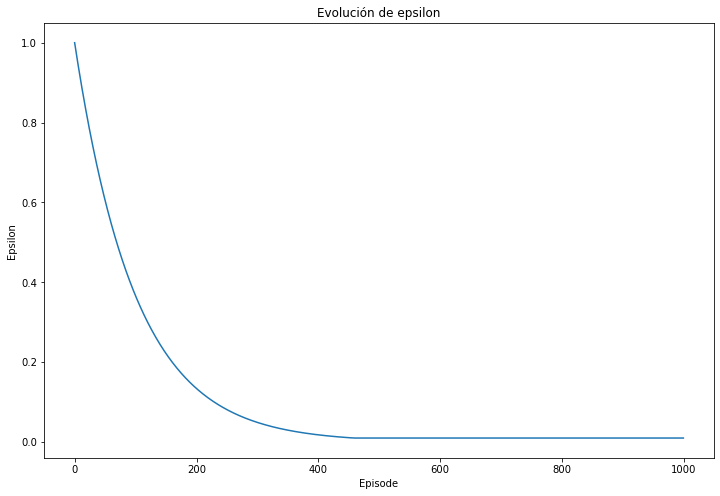

In [32]:
agent_dqn_occupancy.plot_rewards()
agent_dqn_occupancy.plot_loss()
agent_dqn_occupancy.plot_epsilon()

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 3.3 (2 ptos) - </strong> Probar el agente y mostrar el comportamiento del mismo:
</div>

Primero vamos a realizar una ejecución del agente en el entorno de prueba a nivel visual, básicamente para ver cómo se comporta.

Obs inicial:


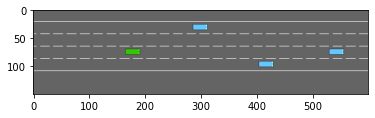


Acción: LANE_RIGHT -> recommpensa: 0.8666666666666667
Nuevo estado:


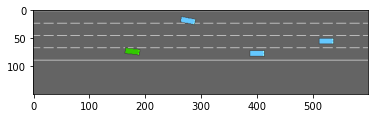


Acción: LANE_RIGHT -> recommpensa: 0.8666666666666667
Nuevo estado:


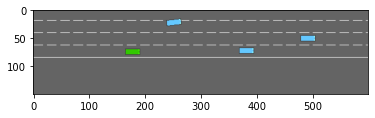


Acción: LANE_RIGHT -> recommpensa: 0.8666666666666667
Nuevo estado:


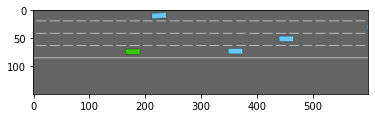


Acción: LANE_RIGHT -> recommpensa: 0.8666666666666667
Nuevo estado:


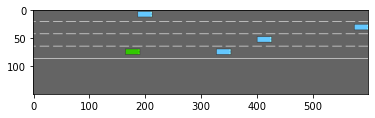


Acción: LANE_RIGHT -> recommpensa: 0.8666666666666667
Nuevo estado:


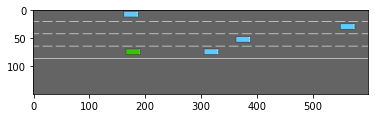


Acción: SLOWER -> recommpensa: 0.7561184312834853
Nuevo estado:


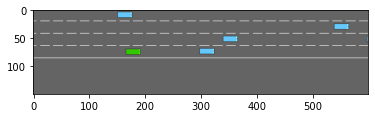


Acción: LANE_RIGHT -> recommpensa: 0.7372270384978186
Nuevo estado:


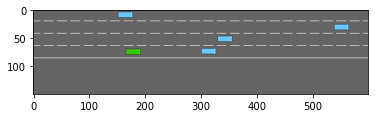


Acción: LANE_RIGHT -> recommpensa: 0.7339987217350469
Nuevo estado:


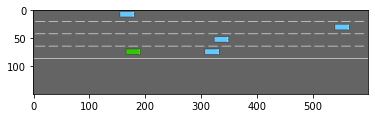


Acción: LANE_RIGHT -> recommpensa: 0.7334470403826429
Nuevo estado:


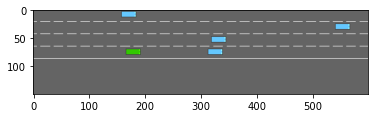


Acción: LANE_RIGHT -> recommpensa: 0.7333527645302546
Nuevo estado:


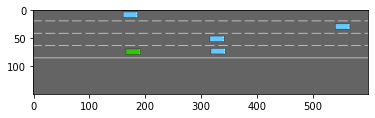


Acción: FASTER -> recommpensa: 0.8438848892794533
Nuevo estado:


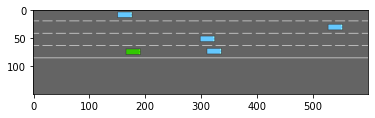


Acción: LANE_RIGHT -> recommpensa: 0.8627735289473201
Nuevo estado:


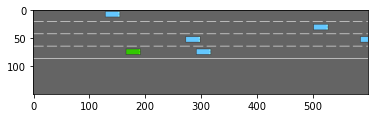


Acción: LANE_LEFT -> recommpensa: 0.8437791530124289
Nuevo estado:


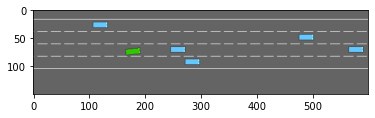


Acción: SLOWER -> recommpensa: 0.7337825185829341
Nuevo estado:


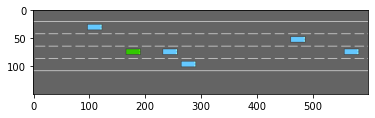


Acción: LANE_LEFT -> recommpensa: 0.6927631656882386
Nuevo estado:


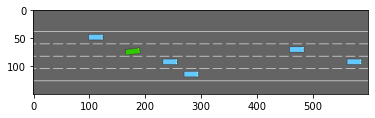


Acción: FASTER -> recommpensa: 0.800099192594764
Nuevo estado:


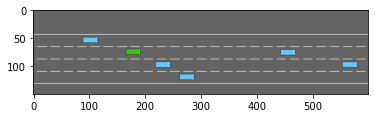


Acción: FASTER -> recommpensa: 0.9289898921277855
Nuevo estado:


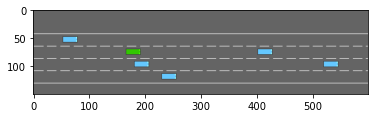


Acción: FASTER -> recommpensa: 0.9510157962307116
Nuevo estado:


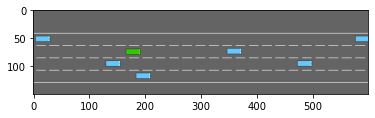


Acción: LANE_RIGHT -> recommpensa: 0.9770019863211276
Nuevo estado:


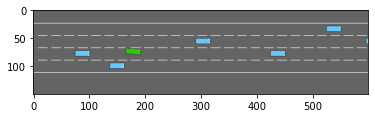


Acción: SLOWER -> recommpensa: 0.8670969687621314
Nuevo estado:


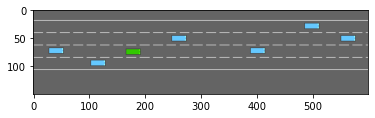


Acción: FASTER -> recommpensa: 0.9588637297181011
Nuevo estado:


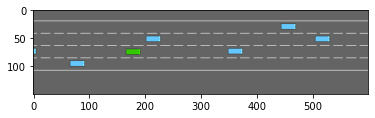


Acción: SLOWER -> recommpensa: 0.8639973541120444
Nuevo estado:


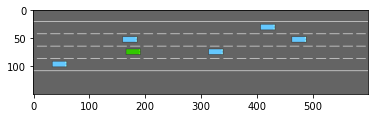


Acción: LANE_RIGHT -> recommpensa: 0.8700080288815673
Nuevo estado:


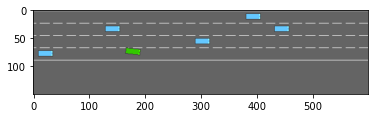


Acción: FASTER -> recommpensa: 0.9777859015399989
Nuevo estado:


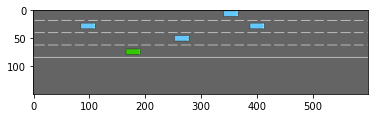


Acción: FASTER -> recommpensa: 0.9962038719303591
Nuevo estado:


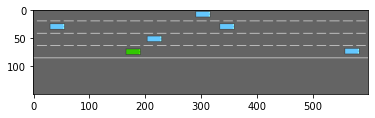


Acción: FASTER -> recommpensa: 0.9993512863757643
Nuevo estado:


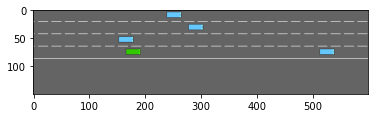


Acción: LANE_RIGHT -> recommpensa: 0.9998891424739765
Nuevo estado:


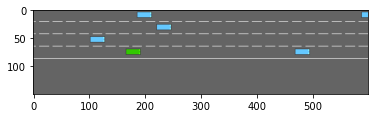


Acción: LANE_RIGHT -> recommpensa: 0.9999810557530829
Nuevo estado:


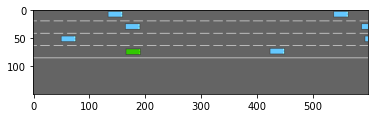


Acción: LANE_RIGHT -> recommpensa: 0.999996762651088
Nuevo estado:


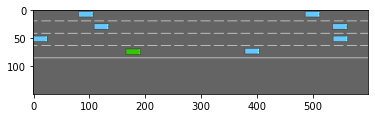


Acción: LANE_RIGHT -> recommpensa: 0.9999994467751597
Nuevo estado:


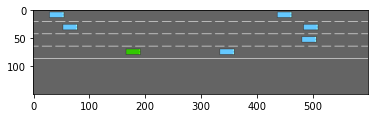


Acción: LANE_RIGHT -> recommpensa: 0.9999999054603838
Nuevo estado:


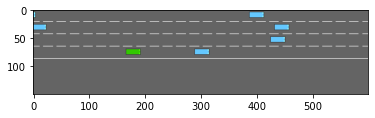


Acción: LANE_LEFT -> recommpensa: 0.9777777616220696
Nuevo estado:


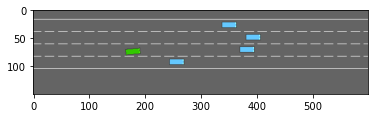


Acción: FASTER -> recommpensa: 0.9777777750169574
Nuevo estado:


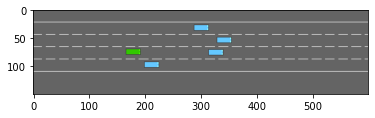


Acción: FASTER -> recommpensa: 0.977777777305986
Nuevo estado:


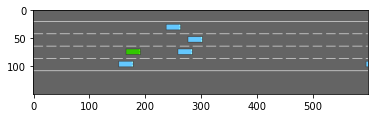


Acción: LANE_RIGHT -> recommpensa: 0.9999999999193765
Nuevo estado:


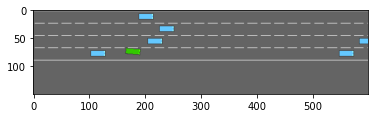


Acción: SLOWER -> recommpensa: 0.8894517646030411
Nuevo estado:


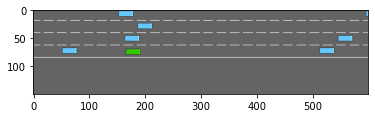


Acción: LANE_RIGHT -> recommpensa: 0.8705603718287974
Nuevo estado:


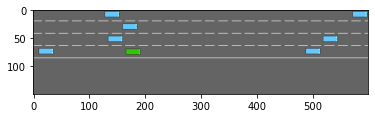


Acción: LANE_RIGHT -> recommpensa: 0.867332055067978
Nuevo estado:


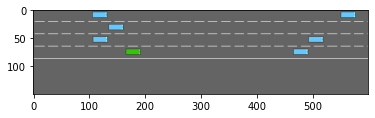


Acción: LANE_RIGHT -> recommpensa: 0.8667803737159075
Nuevo estado:


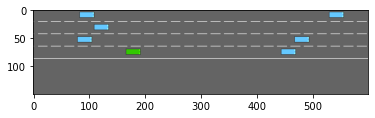


Acción: LANE_RIGHT -> recommpensa: 0.866686097863576
Nuevo estado:


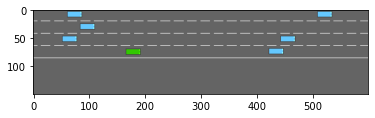

Episodio terminado después de 40 pasos y la recompensa fue 35.488884883924676


In [34]:
# Carga del modelo entrenado
modelo = torch.load("DQN_occupancy.pth")['state_dic']
agent_dqn_occupancy.main_network.load_state_dict(modelo)

obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial:")
plt.imshow(env.render(mode="rgb_array"))
plt.show()
# print(obs)

while not done:
    # Obtener la acción y la ejecutamos
    action = agent_dqn_occupancy.main_network.get_action(obs)
    new_obs, reward, done, info = env.step(action)
    
    # Imprimimos el paso
    print("\nAcción: {} -> recommpensa: {}".format(env.action_type.actions[action], reward))
    print("Nuevo estado:")
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
    env.close()
#     print(new_obs)
    
    t += 1
    total_reward += reward
    obs = new_obs
    
print("Episodio terminado después de {} pasos y la recompensa fue {}".format(t, total_reward))

Vamos a visualizar el comportamiento del agente durante 100 episodios para ver cómo se comporta, es decir, cómo es de bueno nuestro agente a partir de las recompensas obtenidas.

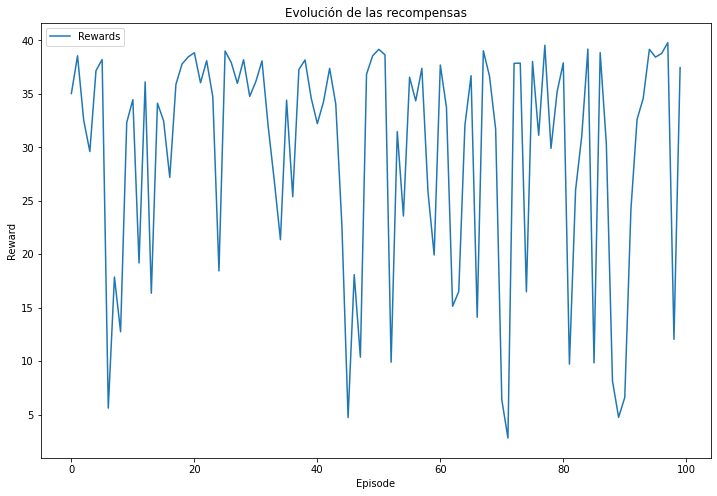

In [37]:
# Carga del modelo entrenado
modelo = torch.load("DQN_occupancy.pth")['state_dic']
agent_dqn_occupancy.main_network.load_state_dict(modelo)

rew_episodio = []
for episodio in range(100):
    obs = env.reset()
    pos_paso = []
    rew_paso = 0
    
    while True:
        
        accion = agent_dqn_occupancy.main_network.get_action(obs) # USO DEL MODELO
        new_obs, reward, done, info = env.step(accion)
        
        obs = new_obs
        rew_paso += reward
        
        if done:
            break
            
    rew_episodio.append(rew_paso)

plt.figure(figsize=(12,8))
plt.plot(rew_episodio, label='Rewards')
plt.title("Evolución de las recompensas")
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(loc="upper left")
plt.show()